In [53]:
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
import gzip
from datetime import datetime, timedelta
from statistics import mean, median
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow
import tensorflow.keras as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, LeakyReLU, BatchNormalization, ReLU, LSTM, Conv1D, Conv2D
from tensorflow.keras.activations import sigmoid, tanh
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import MinMaxScaler

from tqdm import tqdm
import csv
import random
import math

from sklearn.metrics import accuracy_score as accuracy
from sklearn.metrics import precision_score as precision
from sklearn.metrics import recall_score as recall
from sklearn.metrics import f1_score as f1

import pickle

In [54]:
def extract_model(filename):
    model = tf.models.load_model(filename)
    return model
    
def retrieve_data(filename):
    if "combined" in filename:
        df = pd.read_csv(filename)
    else:
        df = pd.read_csv(filename, index_col=0)
    df["Date"] = pd.to_datetime(df["Date"])
    return df

def create_classification_data(df, lookback, column):
    rows = []
    columns = ['Date', column] # Date and SP500_relative_change_perc_1 from t-0 are added first as target variables 
    # create column names based on original with the addition of t-i where i is lookback
    for i in range(1, lookback + 1): # starts at 1 since we do not want t-0 variables apart from 'Date' and 'SP500_relative_change_perc_1'
        new_columns = df.columns.tolist() # starts at 1 to exclude 'Date' column
        for x in range(len(new_columns)):
            new_columns[x] = new_columns[x] + "_t-" + str(i)
        columns = columns + new_columns
    
    # create lookback data
    for i, row in enumerate(df.iterrows()):
        if i > lookback: # lookback cannot be determined for earlier rows
            new_row = [row[1]['Date'], row[1][column]]
#             new_row = [row[1][0], row[1][1]] # add target 'Date' and 'SP500_relative_change_perc_1 '
            for x in range(1, lookback + 1): # starts at 1 since we do not want t-0 variables apart from 'Date' and 'SP500_relative_change_perc_1'
                add_row = df.iloc[i - x].tolist() # starts at 1 to exclude 'Date' column
                new_row = new_row + add_row
            rows.append(new_row)
    
    df2 = pd.DataFrame(rows)
    df2.columns = columns
                       
    for col in columns:
        if col[:4] == "Date" and col != "Date":
            df2 = df2.drop([col], axis=1)
    return df2

def create_train(df, year_val, year_test, column, perc_train=None):
    # assumes years_train < year_val < year_test
    df["Date"] = pd.to_datetime(df["Date"])

    val = df[df['Date'].dt.year == year_val]
    test = df[df['Date'].dt.year == year_test]
    train = df[df['Date'].dt.year < year_val]
    y_train = train[column]
    x_train = train
    return x_train


def create_val(df, year_val, year_test, column, perc_train=None):
    # assumes years_train < year_val < year_test
    df["Date"] = pd.to_datetime(df["Date"])
    val = df[df['Date'].dt.year == year_val]
    test = df[df['Date'].dt.year == year_test]
    train = df[df['Date'].dt.year < year_val]
    y_val = val[column]
    x_val = val
#     display(x_val)
    return x_val

def create_test(df, year_val, year_test, column, perc_train=None):
    print("test", len(df))
    # assumes years_train < year_val < year_test
    df["Date"] = pd.to_datetime(df["Date"])

    val = df[df['Date'].dt.year == year_val]
    test = df[df['Date'].dt.year == year_test]
    train = df[df['Date'].dt.year < year_val]
    y_test = test[column]
    x_test = test
    return x_test

def create_full(df, year_val, year_test, column, perc_train=None):
    df["Date"] = pd.to_datetime(df["Date"])
    y = df[column]
    x = df
    
    return x

In [55]:
"""
    Assumptions:
        You can invest precisely at market open until (exactly) market close
        Investment amounts can be up to 10 decimal points
        Geen commission
        Geen exchange rates
        Trader can go long or short

    Requirements:
        Make sure to consider lookback of each model
        Add recent accuracy (yesterday (0 or 100%), last week, last 2 weeks) as additional features for final NN
"""


'\n    Assumptions:\n        You can invest precisely at market open until (exactly) market close\n        Investment amounts can be up to 10 decimal points\n        Geen commission\n        Geen exchange rates\n        Trader can go long or short\n\n    Requirements:\n        Make sure to consider lookback of each model\n        Add recent accuracy (yesterday (0 or 100%), last week, last 2 weeks) as additional features for final NN\n'

In [56]:
def extract_data(instruments, data, mode):
    year_val = 2018
    year_test = 2019
    for symbol in instruments:
        column = symbol + "_relative_change_perc_1"
        ndir = symbol + "_dir"
        nmag = symbol + "_mag"

        data_dir = data[ndir]
        data_mag = data[nmag]
        if mode == "train":
            data[ndir] = create_train(data_dir, year_val, year_test, column)
            data[nmag] = create_train(data_mag, year_val, year_test, column)
        if mode == "val":
            data[ndir] = create_val(data_dir, year_val, year_test, column)
            data[nmag] = create_val(data_mag, year_val, year_test, column)
        if mode == "test":
            data[ndir] = create_test(data_dir, year_val, year_test, column)
            data[nmag] = create_test(data_mag, year_val, year_test, column)
        if mode == "full":
            data[ndir] = create_full(data_dir, year_val, year_test, column)
            data[nmag] = create_full(data_mag, year_val, year_test, column)
    return data

def init_actions(granularity=0.2):
    possible = []
    for i in np.linspace(0, 1, int(1 / granularity + 1)).tolist():
        possible.append(round(i,1))    
    actions = []
    for x in possible:
        for y in possible:
            for z in possible:
                if x + y + z == 1:
                    actions.append([x, y, z])
#     print(f"Number of possible actions: {len(actions)}")
    return actions

def init_Q(actions):


    Q = {}
    pdir = np.array([0,1])
    pmag = np.array([0,1])

    for i0 in pdir:
        for i1 in pmag:
            for i2 in pdir:
                for i3 in pmag:
                    for i4 in pdir:
                        for i5 in pmag:
                            sub = [i0, i1, i2, i3, i4, i5]
#                             print(sub)
                            Q[repr(sub)] = [0] * len(actions)
    return Q

def choose_action(Q, state, epsilon, actions, epsilon_greedy=True):   
    max_q = -math.inf
    action = None
    action_indices = list(range(0, len(actions)))
    random.shuffle(action_indices)
    if epsilon_greedy:
        prob = random.uniform(0, 1)
        if prob < epsilon:
            # epsilon-greedy implementation where random action is selected epsilon% of the time
            action = random.choice(action_indices)
        else:
            for i in action_indices:
                if Q[str(state)][i] >= max_q:
                    max_q = Q[str(state)][i]
                    action = i
    else:
        # choose action with largest Q value
        for i in action_indices:
            if Q[str(state)][i] >= max_q:
                max_q = Q[str(state)][i]
                action = i
    return action

def predict_individual(date, x, model, column):
    x = x[x['Date'] == date]
    if x.empty:
#         print(date, "empty")
        return 0
    x = x.drop(['Date'], axis=1)
    x = x.drop([column], axis=1)
    x = np.asarray(x)
    x = x.reshape((x.shape[0], 1, x.shape[1]))
    pred = int(model.predict(x, batch_size=1).round())
    return pred

def predict(date, instruments, data, models):
    state = []
    for symbol in instruments:
        column = symbol + "_relative_change_perc_1"
        ndir = symbol + "_dir"
        nmag = symbol + "_mag"
        
        model_dir = models[ndir]
        data_dir = data[ndir]
        model_mag = models[nmag]
        data_mag = data[nmag]
        
        # direction prediction
        pred = predict_individual(date, data_dir, model_dir, column)
        state.append(pred)
        
        # magnitude prediction
        pred = predict_individual(date, data_mag, model_mag, column)
        state.append(pred)
    return state

def translate_action(action_index, actions):
    return actions[action_index]
    

def get_individual_reward(date, x, direction, action, column, capital, risk):
    x = x[x['Date'] == date]
    if x.empty:
        return 0

    relative_change = x[column].iloc[0]
    if np.sign(relative_change) == np.sign(direction):
        relative_change = abs(relative_change)
    else:
        relative_change = -1 * abs(relative_change)
    invested_capital = capital * risk
    profit = relative_change * action * invested_capital
    return profit
    

def get_reward(date, data, state, action, capital, risk):
    profit = 0
    for i, symbol in enumerate(instruments):
        column = symbol + "_relative_change_perc_1"
        ndir = symbol + "_dir"
        data_dir = data[ndir]
    
        if i == 0:
            pred = state[0]
        elif i == 1:
            pred = state[2]
        elif i == 2:
            pred = state[4]
            
        if pred == 0:
            direction = -1
        else:
            direction = 1
            
        profit += get_individual_reward(date, data_dir, direction, action[i], column, capital, risk)
    return profit

def get_reward_eval(date, data, state, action, capital, risk, metrics):
    profit = 0
    for i, symbol in enumerate(instruments):
        column = symbol + "_relative_change_perc_1"
        ndir = symbol + "_dir"
        data_dir = data[ndir]
    
        if i == 0:
            pred = state[0]
        elif i == 1:
            pred = state[2]
        elif i == 2:
            pred = state[4]
            
        if pred == 0:
            direction = -1
        else:
            direction = 1
            
        individual_reward = get_individual_reward(date, data_dir, direction, action[i], column, capital, risk)
        
        if individual_reward > 0:
            metrics['win_trades'] += 1
            metrics['average_win_trade'] += individual_reward
        elif individual_reward < 0:
            metrics['loss_trades'] += 1
            metrics['average_loss_trade'] += individual_reward
        profit += individual_reward
    return profit, metrics

In [57]:
def evaluate_Q(Q, instruments, data, capital, risk, mode):
    
    capitals = []
#     capitals.append(capital)
    data = extract_data(instruments, data, mode)
    dates = data[instruments[0] + "_dir"]['Date'].tolist()
    peak = capital
    valley = capital
    
    metrics = {
        'start_date': dates[0],
        'end_date': dates[-1],
        'profit' : 0,
        'relative_profit': 0,
        'max_drawdown': 0,
        'max_run_up': 0,
        
        'trades': 0,
        'win_trades': 0,
        'loss_trades': 0,
        'relative_win_trades': 0,
        
        'days_traded': len(dates),
        'win_days': 0,
        'loss_days': 0,
        'relative_win_days': 0,
        
        'average_trade': 0,
        'average_win_trade': 0,
        'average_loss_trade': 0,
        'ratio_wl_trade': 0,
        
        'average_day': 0,
        'average_win_day': 0, 
        'average_loss_day': 0,
        'ratio_wl_day': 0,
    }
    
    actions = init_actions()

    for d in tqdm(dates, total=len(dates)):
        date = pd.to_datetime(d)
        state = predict(date, instruments, data, models)
        action_index = choose_action(Q, state, epsilon, actions, False)
        action = translate_action(action_index, actions)
        for a in action:
            if a > 0:
                metrics['trades'] += 1
        reward, metrics = get_reward_eval(date, data, state, action, capital, risk, metrics)

        metrics['profit'] += reward
        if reward >= 0:
            metrics['win_days'] += 1 
            metrics['average_win_day'] += reward
        else:
            metrics['loss_days'] += 1   
            metrics['average_loss_day'] += reward
            
        capital += reward
        capitals.append(capital)
        
        if capital > peak:
            peak = capital
        else:
            if peak - capital > metrics['max_drawdown']:
                metrics['max_drawdown'] = peak - capital
            
        if capital < valley:
            valley = capital
        else:
            if capital - valley > metrics['max_run_up']:
                metrics['max_run_up'] = capital - valley
        
    metrics['relative_profit'] = metrics['profit'] / capitals[0]
    metrics['relative_win_trades'] = metrics['win_trades'] / metrics['trades']
    metrics['relative_win_days'] = metrics['win_days'] / metrics['days_traded']
    
    metrics['average_day'] = metrics['average_day'] / len(dates)
    metrics['average_win_day'] = metrics['average_win_day'] / metrics['win_days']
    metrics['average_loss_day'] = abs(metrics['average_loss_day'] / metrics['loss_days'])
    metrics['ratio_wl_day'] = metrics['average_win_day'] / metrics['average_loss_day']
    
    metrics['average_trade'] = metrics['average_trade'] / metrics['trades']
    metrics['average_win_trade'] = metrics['average_win_trade'] / metrics['win_trades']
    metrics['average_loss_trade'] = abs(metrics['average_loss_trade'] / metrics['loss_trades'])
    metrics['ratio_wl_trade'] = metrics['average_win_trade'] / metrics['average_loss_trade']
    
    return metrics, capitals, dates

def run(alpha, gamma, epsilon, decay, episodes, instruments, data, models, capital, risk, mode):
    actions = init_actions()
    Q = init_Q(actions)
    total_rewards = []
    mean_diffs = []
    
    data = extract_data(instruments, data, mode)
#     display(data)
    dates = data[instruments[0] + "_dir"]['Date'].tolist()
    
    for i in range(episodes):
        print(f"Executing episode {i + 1} / {episodes}")
        total_reward = 0
        diffs = []
        
        for d in tqdm(dates, total=len(dates)):
            date = pd.to_datetime(d)
            state = predict(date, instruments, data, models)
            action_index = choose_action(Q, state, epsilon, actions)
            action = translate_action(action_index, actions)
            reward = get_reward(date, data, state, action, capital, risk)

            Q_old = Q[str(state)][action_index]
            Q[str(state)][action_index] += alpha * reward
            Q_new = Q[str(state)][action_index] 
            diffs.append(abs(Q_new - Q_old))
            
            total_reward += reward
            capital += reward
        
        Q_file = f"Models/Q/Q{i}.pickle"
        with open(Q_file, 'wb') as handle:
            pickle.dump(Q, handle, protocol=pickle.HIGHEST_PROTOCOL)
        epsilon = epsilon * decay
        mean_diffs.append(sum(diffs) / len(diffs))
        total_rewards.append(total_reward)
    return Q, total_rewards, mean_diffs

In [58]:
def init_models_data():
    instruments = ['SP500', 'NASDAQ', 'US30']

    model_mag_sp500 = extract_model("Models/SP500_LSTM_large-small_model")
    model_mag_us30 = extract_model("Models/US30_LSTM_large-small_model")
    model_mag_nasdaq = extract_model("Models/NASDAQ_LSTM_large-small_model")

    model_dir_sp500 = extract_model("Models/SP500_NN_up-down_model_shap_l3")
    model_dir_us30 = extract_model("Models/US30_NN_up-down_model_shap_l3")
    model_dir_nasdaq = extract_model("Models/NASDAQ_NN_up-down_model_shap_l3")

    models = {
        'SP500_mag': model_mag_sp500,
        'US30_mag': model_mag_us30,
        'NASDAQ_mag': model_mag_nasdaq,
        'SP500_dir': model_dir_sp500,
        'US30_dir': model_dir_us30,
        'NASDAQ_dir': model_dir_nasdaq
    }
    
    features_dir_sp500 = ['SP500_stochastic_K_50_t-5', 'SP500_williams_R_10_t-3', 'SP500_relative_change_perc_1_t-4', 'SP500_williams_R_50_t-3', 'Copper_F_relative_change_perc_1_t-7', 'SP500_stochastic_K_20_t-4', 'Gold_F_relative_change_perc_1_t-10', 'SP500_stochastic_K_5_t-4', 'SP500_momentum_16_t-7', 'SP500_stochastic_K_10_t-10', 'Silver_F_relative_change_perc_1_t-5', 'Gold_F_relative_change_perc_1_t-2', 'SP500_stochastic_K_50_t-4', 'SP500_williams_R_50_t-4', 'SP500_stochastic_K_10_t-1', 'SP500_stochastic_K_10_t-7', 'SP500_AD_oscillator_t-9', 'SP500_AD_oscillator_t-1', 'SP500_stochastic_K_5_t-2', 'Silver_F_relative_change_perc_1_t-10', 'SP500_stochastic_D_5_5_t-5', 'SP500_williams_R_10_t-7']
    features_dir_us30 = ['USDCAD_relative_change_perc_5_t-2', 'USDCAD_relative_change_perc_10_t-3', 'Corn_F_relative_change_perc_5_t-2', 'SSE50_relative_change_perc_5_t-2', 'NaturalGas_F_Volume_t-2', 'USDCHF_relative_change_perc_20_t-2', 'HS50_relative_change_perc_50_t-3', 'UK100_relative_change_perc_1_t-2', 'NZDUSD_relative_change_perc_10_t-2', 'UK100_F_relative_change_perc_10_t-3', 'US30_momentum_4_t-3', 'US30_relative_change_perc_20_t-1', 'MSFT_relative_change_perc_1_t-1', 'HS50_relative_change_perc_5_t-3', 'BrentOil_F_relative_change_perc_1_t-3', 'USDJPY_relative_change_perc_5_t-2', 'NIKKEI225_F_relative_change_perc_20_t-2', 'MSFT_relative_change_perc_5_t-2', 'NIKKEI225_relative_change_perc_10_t-1', 'US30_OBV_t-2', 'USDJPY_relative_change_perc_1_t-1', 'NIKKEI225_relative_change_perc_5_t-1', 'GS_relative_change_perc_1_t-1', 'NIKKEI225_F_relative_change_perc_10_t-3']
    features_dir_nasdaq = ['WTIOil_F_relative_change_perc_5_t-2', 'MSFT_relative_change_perc_5_t-2', 'CAC40_F_Volume_t-2', 'Copper_F_relative_change_perc_1_t-3', 'NIKKEI225_F_relative_change_perc_20_t-1', 'NASDAQ_momentum_8_t-2', 'USDJPY_relative_change_perc_1_t-1', 'NASDAQ_F_relative_change_perc_50_t-1', 'NaturalGas_F_relative_change_perc_20_t-3', 'NIKKEI225_relative_change_perc_50_t-3', 'SSE50_F_relative_change_perc_20_t-1', 'HS50_relative_change_perc_5_t-1', 'USDCHF_relative_change_perc_1_t-2']
    features_dir_sp500.insert(0, 'SP500_relative_change_perc_1')
    features_dir_sp500.insert(0, 'Date')
    features_dir_us30.insert(0, 'US30_relative_change_perc_1')
    features_dir_us30.insert(0, 'Date')
    features_dir_nasdaq.insert(0, 'NASDAQ_relative_change_perc_1')
    features_dir_nasdaq.insert(0, 'Date')

    data_mag_sp500 = create_classification_data(retrieve_data("Dataset v3/SP500_reduced_data_20220425.csv"), 2, 'SP500_relative_change_perc_1')
    data_mag_us30 = create_classification_data(retrieve_data("Dataset v3/US30_reduced_data_20220425.csv"), 12, 'US30_relative_change_perc_1')
    data_mag_nasdaq = create_classification_data(retrieve_data("Dataset v3/NASDAQ_reduced_data_20220425.csv"), 18, 'NASDAQ_relative_change_perc_1')

    data_dir_sp500 = create_classification_data(retrieve_data("Dataset v3/SP500_reduced_data_20220425.csv"), 10, 'SP500_relative_change_perc_1')
    data_dir_us30 = create_classification_data(retrieve_data("Dataset v3/US30_combined_data_20220422.csv"), 3, 'US30_relative_change_perc_1')
    data_dir_nasdaq = create_classification_data(retrieve_data("Dataset v3/nasdaq_combined_data_20220422.csv"), 3, 'NASDAQ_relative_change_perc_1')
    
    data_dir_sp500 = data_dir_sp500[features_dir_sp500]
#     data_dir_us30 = data_dir_us30[features_dir_us30]
#     data_dir_nasdaq = data_dir_nasdaq[features_dir_nasdaq]
    
    data = {
        'SP500_mag': data_mag_sp500,
        'US30_mag': data_mag_us30,
        'NASDAQ_mag': data_mag_nasdaq,
        'SP500_dir': data_dir_sp500,
        'US30_dir': data_dir_us30,
        'NASDAQ_dir': data_dir_nasdaq
    }
    return instruments, data, models

In [59]:
# alpha = 0.1
alpha = 0.01
gamma = 0.1
epsilon = 0.9
decay = 0.85
# decay = 0.9
# epsiodes = 5
episodes = 20

capital = 100000
risk = 0.05 # capital risked per day

instruments, data, models = init_models_data()

mode = 'train'
Q, total_rewards, mean_diffs = run(alpha, gamma, epsilon, decay, episodes, instruments, data, models, capital, risk, mode)
# profit, risk = evaluate_Q(Q)
# profit = evaluate_Q(Q)

  0%|                                                  | 0/2130 [00:00<?, ?it/s]

Executing episode 1 / 40


  0%|                                          | 1/2130 [00:00<04:15,  8.34it/s]

Executing episode 2 / 40


  0%|                                          | 1/2130 [00:00<04:07,  8.61it/s]

Executing episode 3 / 40


  0%|                                          | 1/2130 [00:00<04:08,  8.56it/s]

Executing episode 4 / 40


  0%|                                          | 1/2130 [00:00<04:06,  8.63it/s]

Executing episode 5 / 40


  0%|                                          | 1/2130 [00:00<04:05,  8.67it/s]

Executing episode 6 / 40


  0%|                                          | 1/2130 [00:00<03:47,  9.35it/s]

Executing episode 7 / 40


  0%|                                          | 1/2130 [00:00<03:52,  9.15it/s]

Executing episode 8 / 40


  0%|                                          | 1/2130 [00:00<03:47,  9.36it/s]

Executing episode 9 / 40


  0%|                                          | 1/2130 [00:00<04:02,  8.78it/s]

Executing episode 10 / 40


  0%|                                          | 1/2130 [00:00<04:28,  7.94it/s]

Executing episode 11 / 40


  0%|                                          | 1/2130 [00:00<04:15,  8.32it/s]

Executing episode 12 / 40


  0%|                                          | 1/2130 [00:00<04:39,  7.62it/s]

Executing episode 13 / 40


  0%|                                          | 1/2130 [00:00<04:22,  8.10it/s]

Executing episode 14 / 40


  0%|                                          | 1/2130 [00:00<04:18,  8.25it/s]

Executing episode 15 / 40


  0%|                                          | 1/2130 [00:00<03:59,  8.88it/s]

Executing episode 16 / 40


  0%|                                          | 1/2130 [00:00<04:43,  7.50it/s]

Executing episode 17 / 40


  0%|                                          | 1/2130 [00:00<04:23,  8.07it/s]

Executing episode 18 / 40


  0%|                                          | 1/2130 [00:00<04:45,  7.46it/s]

Executing episode 19 / 40


  0%|                                          | 1/2130 [00:00<04:25,  8.03it/s]

Executing episode 20 / 40


  0%|                                          | 1/2130 [00:00<05:02,  7.03it/s]

Executing episode 21 / 40


  0%|                                          | 1/2130 [00:00<04:10,  8.48it/s]

Executing episode 22 / 40


  0%|                                          | 1/2130 [00:00<04:31,  7.85it/s]

Executing episode 23 / 40


  0%|                                          | 1/2130 [00:00<04:35,  7.72it/s]

Executing episode 24 / 40


  0%|                                          | 1/2130 [00:00<04:04,  8.69it/s]

Executing episode 25 / 40


  0%|                                          | 1/2130 [00:00<04:32,  7.82it/s]

Executing episode 26 / 40


  0%|                                          | 1/2130 [00:00<04:09,  8.55it/s]

Executing episode 27 / 40


  0%|                                          | 1/2130 [00:00<04:11,  8.48it/s]

Executing episode 28 / 40


  0%|                                          | 1/2130 [00:00<04:46,  7.44it/s]

Executing episode 29 / 40


  0%|                                          | 1/2130 [00:00<04:01,  8.82it/s]

Executing episode 30 / 40


  0%|                                          | 1/2130 [00:00<03:58,  8.92it/s]

Executing episode 31 / 40


  0%|                                          | 1/2130 [00:00<04:50,  7.32it/s]

Executing episode 32 / 40


  0%|                                          | 1/2130 [00:00<04:03,  8.75it/s]

Executing episode 33 / 40


  0%|                                          | 1/2130 [00:00<05:26,  6.53it/s]

Executing episode 34 / 40


  0%|                                                  | 0/2130 [00:00<?, ?it/s]

Executing episode 35 / 40


  0%|                                          | 1/2130 [00:00<04:44,  7.49it/s]

Executing episode 36 / 40


  0%|                                          | 1/2130 [00:00<04:59,  7.12it/s]

Executing episode 37 / 40


  0%|                                          | 1/2130 [00:00<05:24,  6.56it/s]

Executing episode 38 / 40


  0%|                                          | 1/2130 [00:00<04:49,  7.37it/s]

Executing episode 39 / 40


  0%|                                          | 1/2130 [00:00<04:43,  7.52it/s]

Executing episode 40 / 40


100%|███████████████████████████████████████| 2130/2130 [06:47<00:00,  5.23it/s]


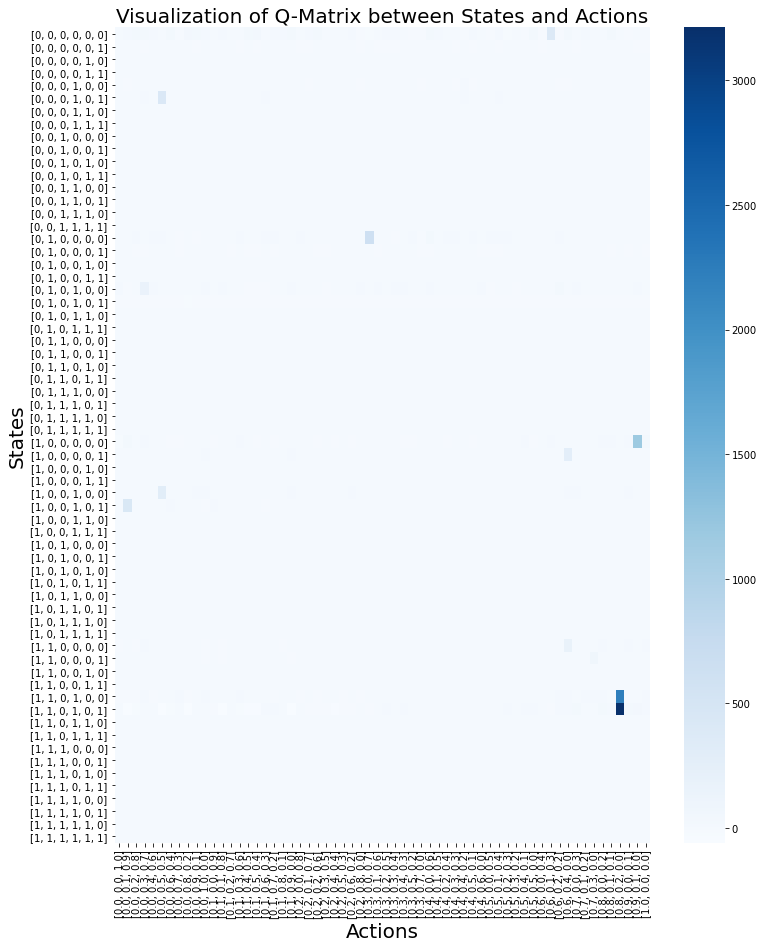

In [60]:
def visualize_Q(Q, actions, states):
    Q2 = []
    for i in Q:
        Q2.append(Q[i])
    plt.rcParams["figure.figsize"] = (12,15)
    ax = sns.heatmap(Q2, cmap="Blues", yticklabels=states, xticklabels=actions)
    ax.set_title("Visualization of Q-Matrix between States and Actions", fontsize=20)
    ax.set_xlabel("Actions", fontsize=20)
    ax.set_ylabel("States", fontsize=20)
#     plt.savefig("Plots/Q_matrix.png")
    plt.show()
    
    
# possible = []
# for i in np.linspace(0, 1, int(1 / 0.2 + 1)).tolist():
#     possible.append(round(i,1))    
# actions = []
# for x in possible:
#     for y in possible:
#         for z in possible:
#             if x + y + z == 1:
#                 actions.append(str([x, y, z]))

actions = init_actions()
states = []
pdir = np.array([0,1])
pmag = np.array([0,1])
for i0 in pdir:
    for i1 in pmag:
        for i2 in pdir:
            for i3 in pmag:
                for i4 in pdir:
                    for i5 in pmag:
                        sub = [i0, i1, i2, i3, i4, i5]
                        states.append(str(sub))
                        
visualize_Q(Q, actions, states)

In [61]:
def plot_capitals(dates, capitals):
    fig1 = make_subplots(rows=1, cols=1, specs=[[{'type':'xy'}]])
    
    fig1.add_trace(go.Scatter(x=dates, y=capitals, mode="lines"), row=1, col=1)
#     fig1.add_vline(x=2.5, line_width=3, line_dash="dash", line_color="green")

    fig1.update_layout(
        title = f'Compounded Capital over Time', 
        xaxis1 = dict(title_text = 'Day'),
        yaxis1 = dict(title_text = 'Capital')
    )
    fig1.show()
    
capital = 1000000
risk = 0.05

print("Evaluating...")

instruments, data, models = init_models_data()
mode = 'train'
metrics, capitals, dates = evaluate_Q(Q, instruments, data, capital, risk, mode)
# print(f"Profit in evaluation: {profit}")
plot_capitals(dates, capitals)
display(metrics)
df = pd.DataFrame({'dates': dates, 'capitals': capitals})
df.to_csv("Portfolio Output/predict_train_0.1.csv")


instruments, data, models = init_models_data()
mode = 'val'
metrics, capitals, dates = evaluate_Q(Q, instruments, data, capital, risk, mode)
# print(f"Profit in evaluation: {profit}")
plot_capitals(dates, capitals)
display(metrics)
df = pd.DataFrame({'dates': dates, 'capitals': capitals})
df.to_csv("Portfolio Output/predict_val_0.1.csv")

instruments, data, models = init_models_data()
mode = 'test'
metrics, capitals, dates = evaluate_Q(Q, instruments, data, capital, risk, mode)
# print(f"Profit in evaluation: {profit}")
plot_capitals(dates, capitals)
display(metrics)
df = pd.DataFrame({'dates': dates, 'capitals': capitals})
df.to_csv("Portfolio Output/predict_test_0.1.csv")

instruments, data, models = init_models_data()
mode = 'full'
metrics, capitals, dates = evaluate_Q(Q, instruments, data, capital, risk, mode)
# print(f"Profit in evaluation: {profit}")
plot_capitals(dates, capitals)
display(metrics)
df = pd.DataFrame({'dates': dates, 'capitals': capitals})
df.to_csv("Portfolio Output/predict_full_0.1.csv")

Evaluating...


  0%|                                                  | 0/2130 [00:00<?, ?it/s]

100%|███████████████████████████████████████| 2130/2130 [07:08<00:00,  4.97it/s]


{'start_date': Timestamp('2009-07-17 00:00:00'),
 'end_date': Timestamp('2017-12-29 00:00:00'),
 'profit': 34787.29667844296,
 'relative_profit': 0.034788179061386044,
 'max_drawdown': 10508.699986402877,
 'max_run_up': 44053.4903019683,
 'trades': 5075,
 'win_trades': 2437,
 'loss_trades': 2636,
 'relative_win_trades': 0.48019704433497534,
 'days_traded': 2130,
 'win_days': 1095,
 'loss_days': 1035,
 'relative_win_days': 0.5140845070422535,
 'average_trade': 0.0,
 'average_win_trade': 140.04772515037436,
 'average_loss_trade': 116.27807644651723,
 'ratio_wl_trade': 1.2044207251294712,
 'average_day': 0.0,
 'average_win_day': 246.45256743824214,
 'average_loss_day': 227.1287581318188,
 'ratio_wl_day': 1.0850786552322378}

  0%|                                                   | 0/251 [00:00<?, ?it/s]

100%|█████████████████████████████████████████| 251/251 [00:51<00:00,  4.85it/s]


{'start_date': Timestamp('2018-01-02 00:00:00'),
 'end_date': Timestamp('2018-12-31 00:00:00'),
 'profit': -6569.153137563556,
 'relative_profit': -0.006570426541178031,
 'max_drawdown': 8408.210715993075,
 'max_run_up': 3934.468481767457,
 'trades': 568,
 'win_trades': 277,
 'loss_trades': 291,
 'relative_win_trades': 0.4876760563380282,
 'days_traded': 251,
 'win_days': 126,
 'loss_days': 125,
 'relative_win_days': 0.50199203187251,
 'average_trade': 0.0,
 'average_win_trade': 144.2344689500183,
 'average_loss_trade': 159.86976301277878,
 'ratio_wl_trade': 0.9021998045902483,
 'average_day': 0.0,
 'average_win_day': 181.9908518333664,
 'average_loss_day': 236.0000037485417,
 'ratio_wl_day': 0.7711476650113865}

test 2633


  0%|                                                   | 0/252 [00:00<?, ?it/s]

test 2641
test 2640
test 2625
test 2640
test 2631


100%|█████████████████████████████████████████| 252/252 [00:51<00:00,  4.91it/s]


{'start_date': Timestamp('2019-01-02 00:00:00'),
 'end_date': Timestamp('2019-12-31 00:00:00'),
 'profit': 3277.4815064072122,
 'relative_profit': 0.0032765324915103615,
 'max_drawdown': 2562.764348419849,
 'max_run_up': 4379.477856292855,
 'trades': 559,
 'win_trades': 277,
 'loss_trades': 282,
 'relative_win_trades': 0.49552772808586765,
 'days_traded': 252,
 'win_days': 138,
 'loss_days': 114,
 'relative_win_days': 0.5476190476190477,
 'average_trade': 0.0,
 'average_win_trade': 108.42017889706348,
 'average_loss_trade': 94.87556045418216,
 'ratio_wl_trade': 1.1427619334003551,
 'average_day': 0.0,
 'average_win_day': 161.17975871745537,
 'average_loss_day': 166.36250172457562,
 'ratio_wl_day': 0.9688466874842948}

  0%|                                                  | 0/2633 [00:00<?, ?it/s]

100%|███████████████████████████████████████| 2633/2633 [08:29<00:00,  5.16it/s]


{'start_date': Timestamp('2009-07-17 00:00:00'),
 'end_date': Timestamp('2019-12-31 00:00:00'),
 'profit': 31358.837431598877,
 'relative_profit': 0.03135963285136145,
 'max_drawdown': 12967.109811820672,
 'max_run_up': 44053.4903019683,
 'trades': 6202,
 'win_trades': 2991,
 'loss_trades': 3209,
 'relative_win_trades': 0.48226378587552404,
 'days_traded': 2633,
 'win_days': 1359,
 'loss_days': 1274,
 'relative_win_days': 0.5161412837067983,
 'average_trade': 0.0,
 'average_win_trade': 138.25212099031765,
 'average_loss_trade': 119.08795775956412,
 'ratio_wl_trade': 1.1609244426665335,
 'average_day': 0.0,
 'average_win_day': 232.86202007777868,
 'average_loss_day': 223.7838680173493,
 'ratio_wl_day': 1.0405666062565582}